### **GAN**

### **Libraries**

In [1]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn as nn
import numpy as np
import itertools
import argparse
import torch
import time
import math
import os

### **Configuration**

In [2]:
os.makedirs("images", exist_ok=True)

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=10, help="dimensionality of the latent code")
parser.add_argument("--image_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")

_StoreAction(option_strings=['--sample_interval'], dest='sample_interval', nargs=None, const=None, default=400, type=<class 'int'>, choices=None, required=False, help='interval between image sampling', metavar=None)

In [4]:
opt = parser.parse_args(args=[])

In [5]:
opt

Namespace(n_epochs=200, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=10, image_size=32, channels=1, sample_interval=400)

In [6]:
img_shape = (opt.channels, opt.image_size, opt.image_size)
img_shape

(1, 32, 32)

In [7]:
cuda = True if torch.cuda.is_available() else False
cuda

True

### **Arch**

In [8]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), opt.latent_dim))))
    z = sampled_z * std + mu
    return z

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, opt.latent_dim)
        self.logvar = nn.Linear(512, opt.latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], *img_shape)
        return img

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

### **Binary crossEntropy loss**

In [12]:
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()

### **Initialization**

In [13]:
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

In [14]:
if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

### **Data Loader**

In [15]:
os.makedirs("../../data/mnist", exist_ok=True)

In [16]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST("../../data/mnist", train=True, download=True,
        transform=transforms.Compose([
            transforms.Resize(opt.image_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])
        ])), batch_size=opt.batch_size, shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 43.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.25MB/s]


### **Optimizer**

In [17]:
optimizer_g = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_d = torch.optim.Adam(
    discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2)
)

In [18]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [19]:
def sample_image(row, done):
    z = Variable(Tensor(np.random.normal(0, 1, (row ** 2, opt.latent_dim))))
    generated_images = decoder(z)
    save_image(generated_images.data, "images/%d.png" % done, nrow=row, normalize=True)

### **Training**

In [20]:
d_loss_total = []
g_loss_total = []

start_time = time.time()

for epoch in tqdm(range(opt.n_epochs), desc="training epochs"):
    d_epoch_loss = 0
    g_epoch_loss = 0
    batches = len(dataloader)
    
    for i, (images, _) in enumerate(tqdm(dataloader, desc=f"epoch {epoch+1}/{opt.n_epochs}", total=len(dataloader))):

        valid = Variable(Tensor(images.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(images.shape[0], 1).fill_(0.0), requires_grad=False)

        # config input
        real_images = Variable(images.type(Tensor))
        
        # train generator
        optimizer_g.zero_grad()
        encoded_images = encoder(real_images)
        decoded_images = decoder(encoded_images)
        
        # generator loss
        generator_loss = 0.001 * adversarial_loss(discriminator(encoded_images), valid) + 0.999 * pixelwise_loss(decoded_images, real_images)
        generator_loss.backward()
        optimizer_g.step()
        
        #train discriminator
        optimizer_d.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (images.shape[0], opt.latent_dim))))

        # discriminator loss
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_images.detach()), fake)
        discriminator_loss = (real_loss + fake_loss) * 0.5
        discriminator_loss.backward()
        
        optimizer_d.step()

        g_epoch_loss += generator_loss.item()
        d_epoch_loss += discriminator_loss.item()

        clear_output(wait=True)

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(row=10, done=batches_done)
    
    g_epoch_loss /= batches
    d_epoch_loss /= batches
    g_loss_total.append(g_epoch_loss)
    d_loss_total.append(d_epoch_loss)

    clear_output(wait=True)
    print(f"epoch [{epoch+1}/{opt.n_epochs}] | generator loss: {g_epoch_loss:.4f} | discriminator loss: {d_epoch_loss:.4f}")

total_time = time.time() - start_time
print(f"training completed in {total_time/60:.2f} min")

epoch [200/200] | generator loss: 0.0641 | discriminator loss: 0.3528
training completed in 68.98 min


### **Plot losses**

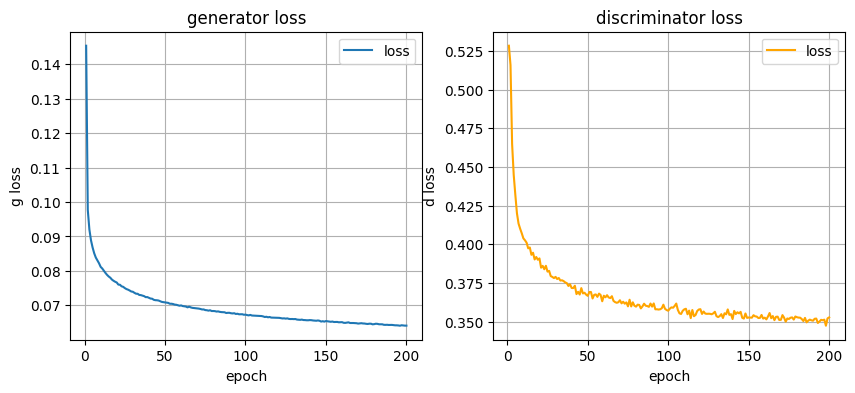

In [21]:
def plot_loss(g_loss, d_loss):
    clear_output(wait=True)
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.plot(range(1, len(g_loss)+1), g_loss, label="loss")
    plt.xlabel("epoch")
    plt.ylabel("g loss")
    plt.title("generator loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(d_loss)+1), d_loss, label="loss", color='orange')
    plt.xlabel("epoch")
    plt.ylabel("d loss")
    plt.title("discriminator loss")
    plt.grid(True)
    plt.legend()

    plt.show()
plot_loss(g_loss_total, d_loss_total)

In [22]:
g_loss_total[-1], d_loss_total[-1]

(0.06410407404036028, 0.35275459734361564)